In [1]:
!pip install cookiecutter
!cookiecutter https://github.com/drivendata/cookiecutter-data-science

##Data Loading

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Importing the necessary package to read the dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Reading the content of the dataset to a dataframe
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/random_survival_forest/data/raw/drugsComTrain_raw.tsv", sep='\t')

df2 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/random_survival_forest/data/raw/drugsComTest_raw.tsv", sep='\t')


In [3]:
# Displaying the records of the train dataframe
print(df)

        Unnamed: 0                  drugName  ...                date usefulCount
0           206461                 Valsartan  ...        May 20, 2012          27
1            95260                Guanfacine  ...      April 27, 2010         192
2            92703                    Lybrel  ...   December 14, 2009          17
3           138000                Ortho Evra  ...    November 3, 2015          10
4            35696  Buprenorphine / naloxone  ...   November 27, 2016          37
...            ...                       ...  ...                 ...         ...
161292      191035                   Campral  ...        May 31, 2015         125
161293      127085            Metoclopramide  ...    November 1, 2011          34
161294      187382                   Orencia  ...      March 15, 2014          35
161295       47128        Thyroid desiccated  ...  September 19, 2015          79
161296      215220              Lubiprostone  ...   December 13, 2014         116

[161297 rows x 

# Data Preprocessing

In [4]:
# Printing the info of the train dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   161297 non-null  int64  
 1   drugName     161297 non-null  object 
 2   condition    160398 non-null  object 
 3   review       161297 non-null  object 
 4   rating       161297 non-null  float64
 5   date         161297 non-null  object 
 6   usefulCount  161297 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 8.6+ MB


In [5]:
# Checking the missing values of each column of train dataframe
df.isnull().sum()

Unnamed: 0       0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

**Observation:**

In "condition" column, there are 899 missing values. Other columns do not have any missing values. However, as they do not actually contribute to the modeling, they are made to remain as it is.

In [6]:
# Creating the target column
df['target'] = df["rating"].apply(lambda x: 1 if x >= 7 else (0 if ((x>4)&(x<7)) else 2))

df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,target
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,1
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,1
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,0
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,1
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,1


**Comment:**

**Features:**
Review: Texual Data

The **target variable** is created according to the mapping given in the paper:

For rating > = 7, target =1 (Positive)

For 4 < rating < 7, target =0 (Neutral)

For rating < 4, target =-1 (Negative)

# Exploratory Data Analysis and Visualization

In [7]:
!pip install -q -U watermark

In [8]:
!pip install -qq transformers

     |████████████████████████████████| 778kB 4.5MB/s 
     |████████████████████████████████| 3.0MB 22.2MB/s 
     |████████████████████████████████| 890kB 60.1MB/s 
     |████████████████████████████████| 1.1MB 53.6MB/s 


In [9]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.0.5
torch 1.6.0+cu101
transformers 3.0.2


In [11]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [12]:
# Printing the rating distribution for all the records
df.rating.value_counts()

10.0    50989
9.0     27531
1.0     21619
8.0     18890
7.0      9456
5.0      8013
2.0      6931
3.0      6513
6.0      6343
4.0      5012
Name: rating, dtype: int64

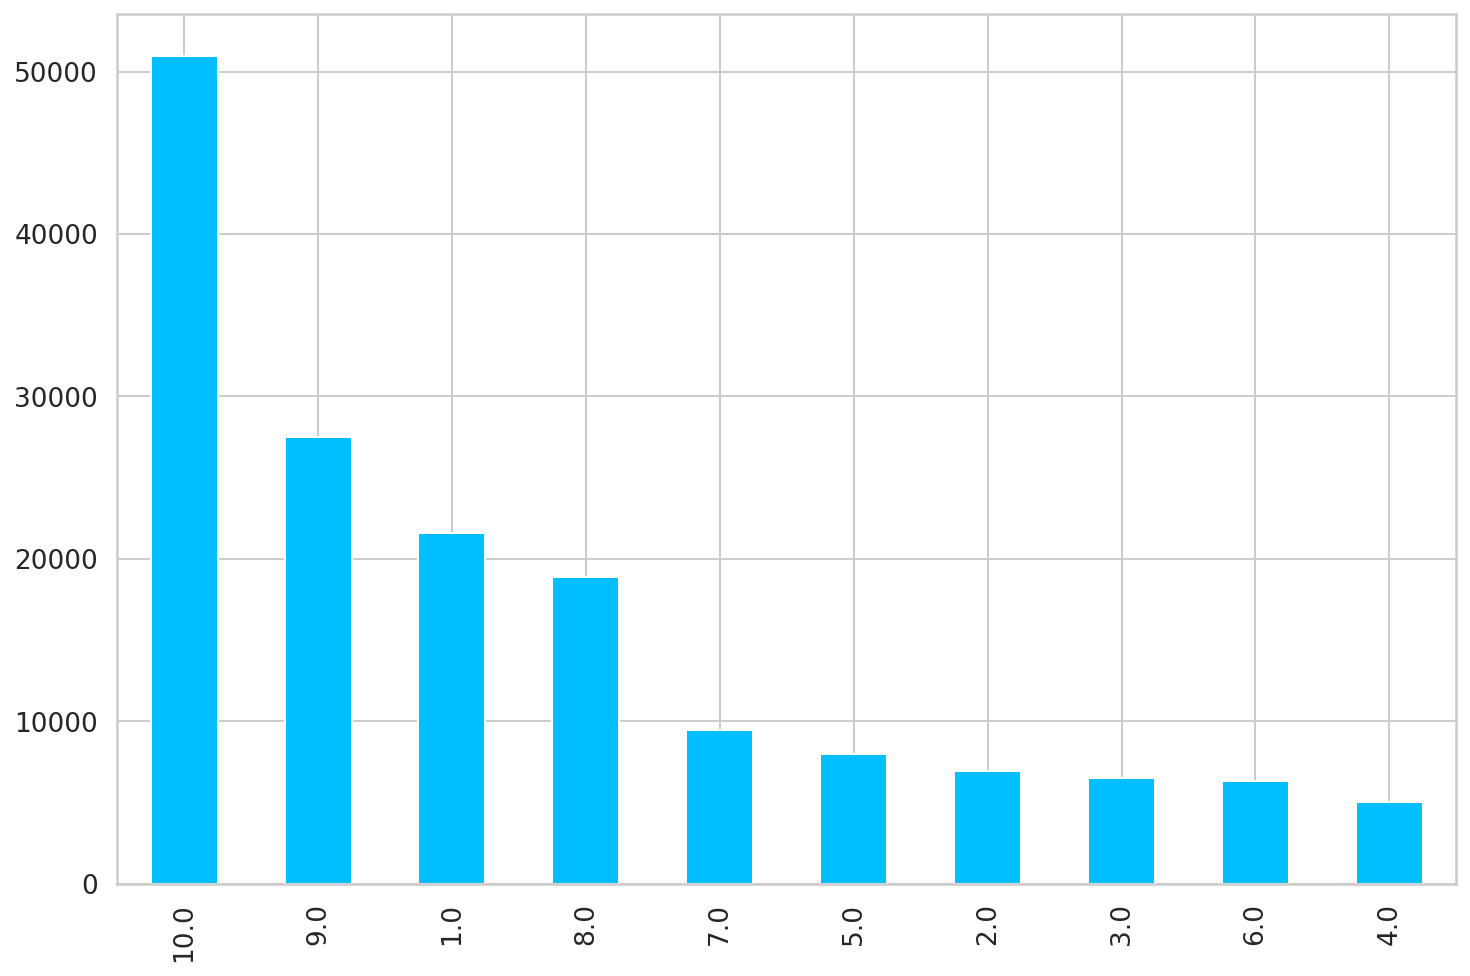

In [13]:
df['rating'].value_counts().plot(kind='bar')

**Observation:**

It is observed that the dataset is hugely imbalanced w.r.t. the ratings.

In [14]:
# Printing the target distribution in all the records
df.target.value_counts()

1    106866
2     40075
0     14356
Name: target, dtype: int64

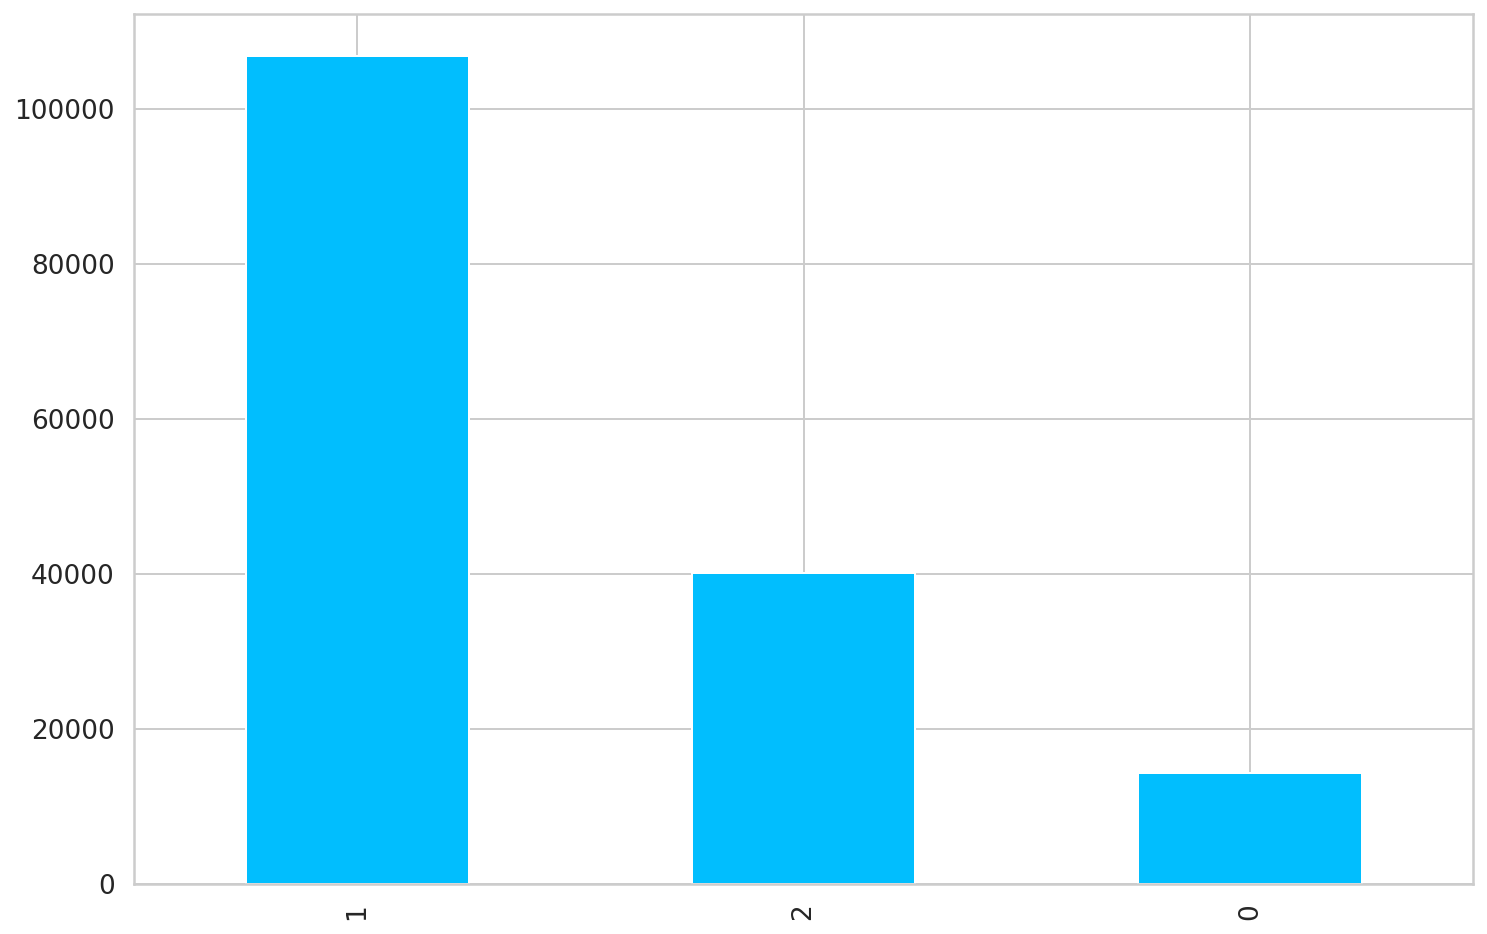

In [15]:
df['target'].value_counts().plot(kind='bar')

**Observation:**

It is observed that the dataset is hugely imbalanced w.r.t. the target classes as well.

In [17]:
# Shuffling the dataset to choose a part of the original train dataset. Also converting it to a balanced dataset.
shuffled_df = df.sample(frac=1,random_state=20)

# Putting all class -1 in a separate dataset.
class_minus1 = shuffled_df.loc[shuffled_df['target'] == 2]

# Putting all class 0 in a separate dataset.
class_0 = shuffled_df.loc[shuffled_df['target'] == 0]

# Putting all class 1 in a separate dataset.
class_1 = shuffled_df.loc[shuffled_df['target'] == 1]

#Randomly selecting 1000 observations from the class 1 dataset
class_1 = class_1.sample(n=1000,random_state=20)

#Randomly selecting 1000 observations from the class 1 dataset
class_0 = class_0.sample(n=1000,random_state=20)

#Randomly selecting 1000 observations from the class 1 dataset
class_minus1 = class_minus1.sample(n=1000,random_state=20)

# Concatenating the dataframes of the three target classes
new_df = pd.concat([class_1, class_0, class_minus1])

# Printing the new dataframe
print(new_df)


        Unnamed: 0                         drugName  ... usefulCount target
12939       155935                           Cialis  ...          87      1
117423      135636                          Intuniv  ...         143      1
28592       151997                          Chantix  ...           4      1
106015       35054                     Levofloxacin  ...           8      1
15717       148571                           Mirena  ...           4      1
...            ...                              ...  ...         ...    ...
141290      159166                         TriNessa  ...          52      2
98869       123656                            Skyla  ...           3      2
66988        95511  Acetaminophen / diphenhydramine  ...          23      2
157784      212755                        Phenergan  ...          22      2
117837       31651                       Miconazole  ...           1      2

[3000 rows x 8 columns]


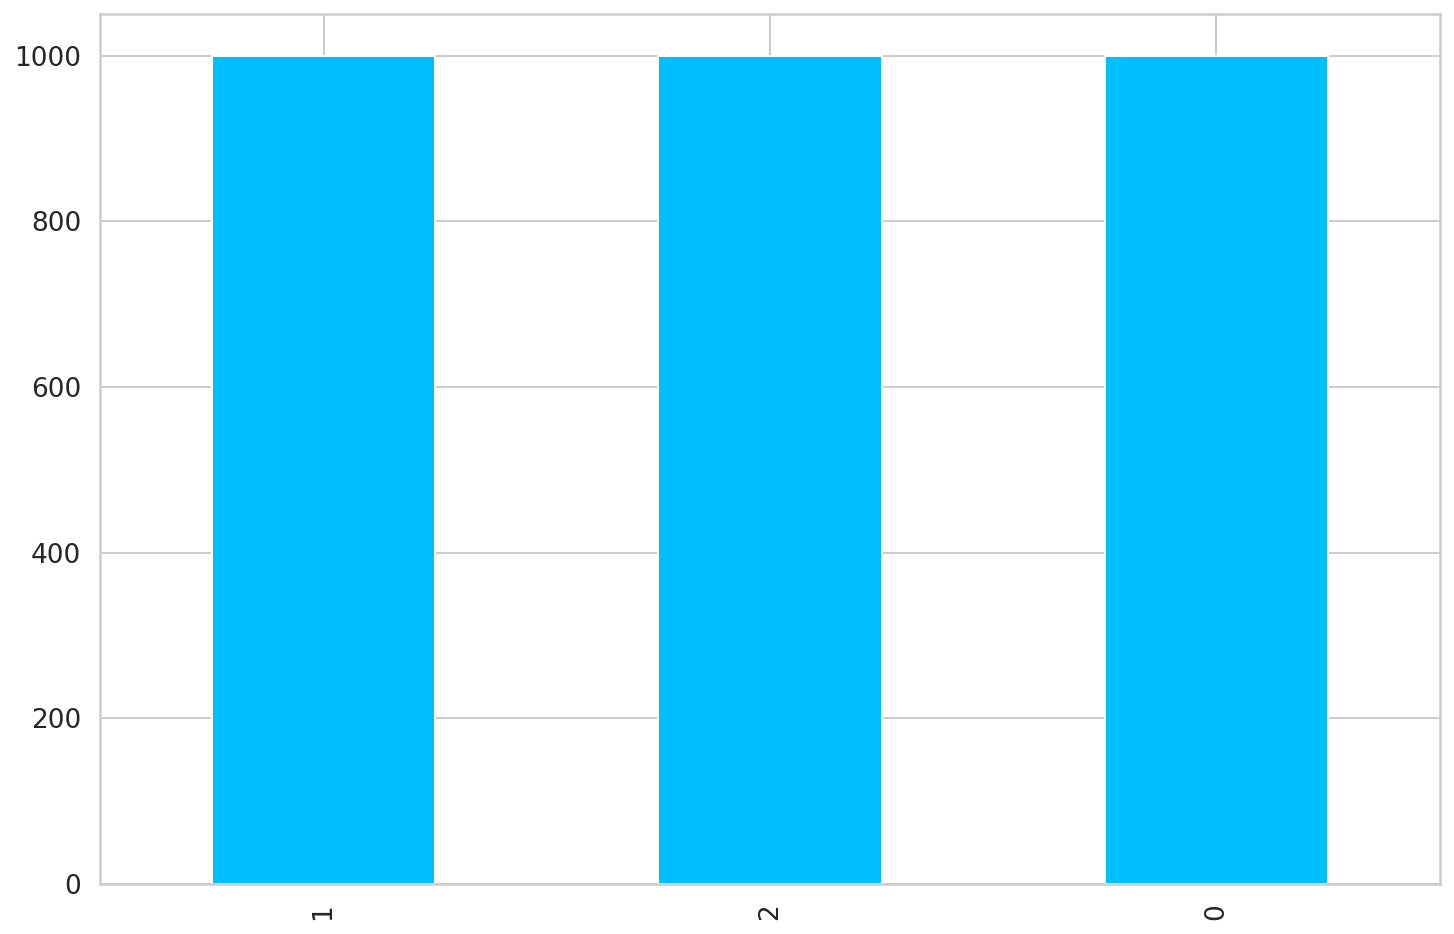

In [18]:
# Plotting the sampled dataframe
new_df['target'].value_counts().plot(kind='bar')

In [19]:
# Creating the target column for the test dataset
df2['target'] = df2["rating"].apply(lambda x: 1 if x >= 7 else (0 if ((x>4)&(x<7)) else 2))

df2.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,target
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,"February 28, 2012",22,1
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,"May 17, 2009",17,1
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,"September 29, 2017",3,1
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,"March 5, 2017",35,1
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,"October 22, 2015",4,1


In [20]:
# Shuffling the dataset to choose a part of the original test dataset. Also converting it to a balanced dataset.
shuffled_df_test = df2.sample(frac=1,random_state=20)

# Putting all class -1 in a separate dataset.
class_minus1_test = shuffled_df_test.loc[shuffled_df_test['target'] == 2]

# Putting all class 0 in a separate dataset.
class_0_test = shuffled_df_test.loc[shuffled_df_test['target'] == 0]

# Putting all class 1 in a separate dataset.
class_1_test = shuffled_df_test.loc[shuffled_df_test['target'] == 1]

#Randomly selecting 1000 observations from the class 1 dataset
class_1_test = class_1_test.sample(n=200,random_state=20)

#Randomly selecting 1000 observations from the class 1 dataset
class_0_test = class_0_test.sample(n=200,random_state=20)

#Randomly selecting 1000 observations from the class 1 dataset
class_minus1_test = class_minus1_test.sample(n=200,random_state=20)

# Concatenating the dataframes of the three target classes
new_df2 = pd.concat([class_1_test, class_0_test, class_minus1_test])

# Printing the new dataframe
print(new_df2)

       Unnamed: 0        drugName  ... usefulCount target
42179      137763          Enbrel  ...          47      1
30325      224035       Alfuzosin  ...         106      1
13845       68079          Plan B  ...           1      1
2677       212621          Rectiv  ...           7      1
37194      172630      Clonazepam  ...          20      1
...           ...             ...  ...         ...    ...
14574      208169       Correctol  ...           5      2
23052       20228        Macrobid  ...          44      2
40731      126959  Metoclopramide  ...           3      2
14339      167593  Levonorgestrel  ...           0      2
9017       113841      Amlodipine  ...           0      2

[600 rows x 8 columns]


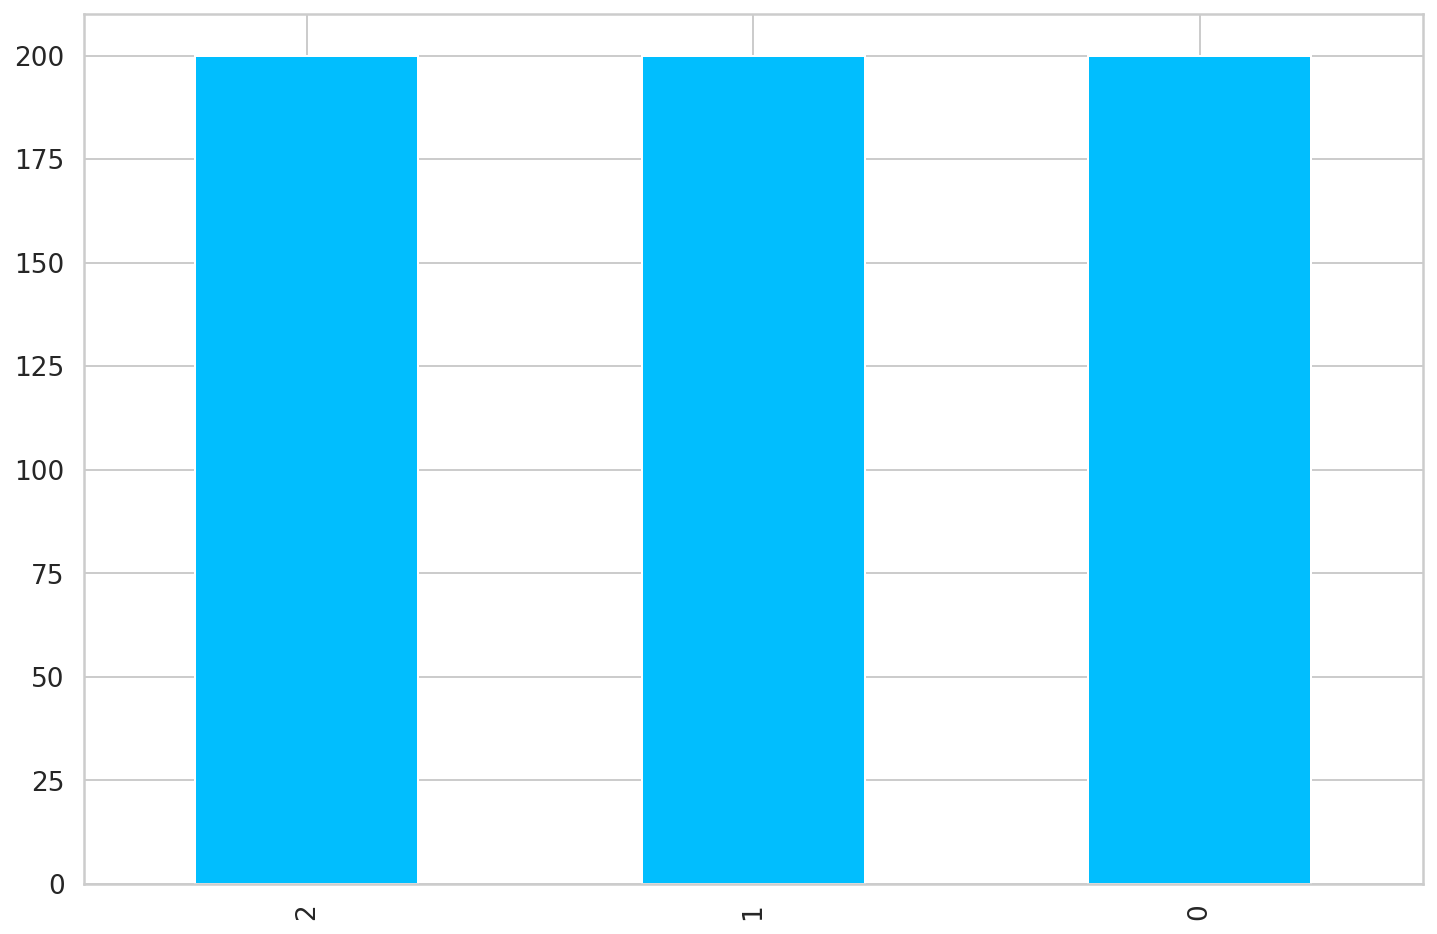

In [21]:
# Plotting the sampled dataframe
new_df2['target'].value_counts().plot(kind='bar')

BERT implementation

In [22]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [23]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [24]:
from torch.utils.data import Dataset, DataLoader
import torch

In [26]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [27]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [29]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['input_ids', 'attention_mask'])

In [30]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [31]:
%%capture

token_lens = []
token_list=[]

for rev in new_df.review:
  tokens = tokenizer.encode(rev, max_length=512)
  token_list.append(tokens)
  token_lens.append(len(tokens))

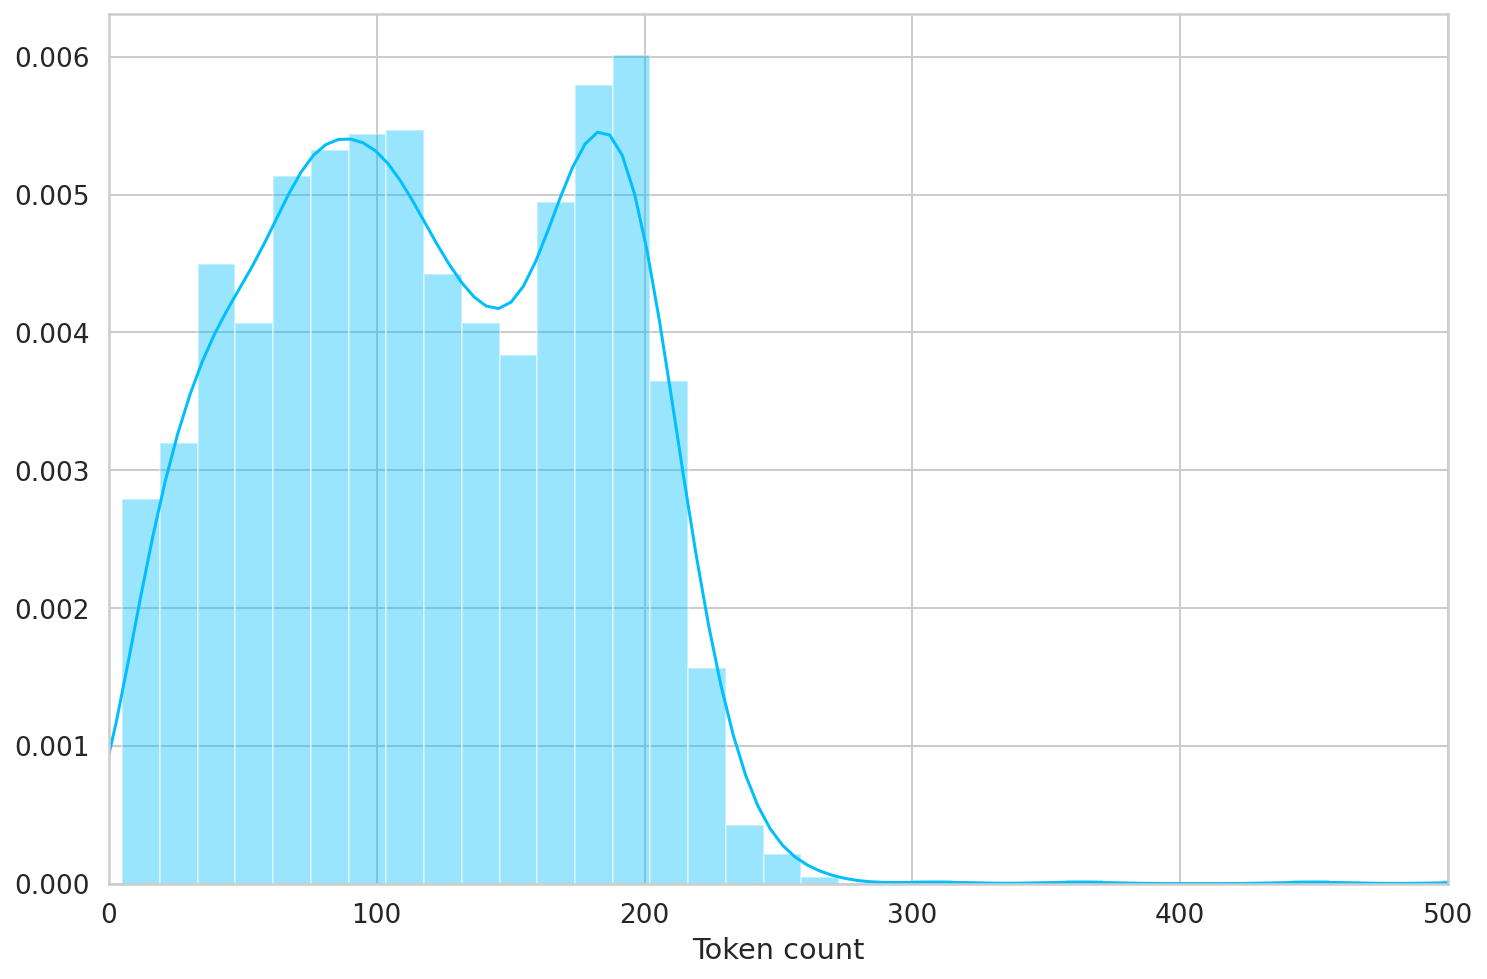

In [32]:
import seaborn as sns
sns.distplot(token_lens)
plt.xlim([0, 500]);
plt.xlabel('Token count');

**Observation**:

We choose the length of the token as 280

In [33]:
MAX_LEN = 260

In [34]:
# Creating the pytorch dataset

class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [35]:
# Splitting the data into train and validation sets

from sklearn.model_selection import train_test_split

new_df_train, new_df_val = train_test_split(new_df, test_size=0.25, random_state=20)


In [36]:
# Printing the shapes of the train and validation datasets
new_df_train.shape, new_df_val.shape, new_df2.shape

((2250, 8), (750, 8), (600, 8))

In [37]:
# Creating dataloaders

def create_data_loader(new_df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=new_df.review.to_numpy(),
    targets=new_df.target.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(ds,batch_size=batch_size,num_workers=4)

In [38]:
# Specifying the batch size
BATCH_SIZE = 16

train_data_loader = create_data_loader(new_df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(new_df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(new_df2, tokenizer, MAX_LEN, BATCH_SIZE)

In [39]:
%%capture
data = next(iter(train_data_loader))
data.keys()

In [40]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 260])
torch.Size([16, 260])
torch.Size([16])


# Sentiment Classification

In [41]:
from transformers import BertModel, BertConfig
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [42]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [43]:
model = SentimentClassifier(new_df['target'].nunique())
model = model.to(device)

In [45]:
#Moving the training data to the GPU:

input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 260])
torch.Size([16, 260])


In [46]:
nn.functional.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3964, 0.1653, 0.4382],
        [0.4974, 0.1350, 0.3676],
        [0.2623, 0.1419, 0.5958],
        [0.5200, 0.1243, 0.3556],
        [0.5667, 0.1814, 0.2519],
        [0.3180, 0.1669, 0.5150],
        [0.4096, 0.1246, 0.4658],
        [0.2974, 0.2410, 0.4615],
        [0.3076, 0.1346, 0.5579],
        [0.2441, 0.1766, 0.5793],
        [0.3758, 0.1819, 0.4423],
        [0.3767, 0.2015, 0.4218],
        [0.5413, 0.0875, 0.3712],
        [0.4896, 0.1055, 0.4049],
        [0.4118, 0.1645, 0.4237],
        [0.3685, 0.1685, 0.4631]], device='cuda:0', grad_fn=<SoftmaxBackward>)

# Training

In [47]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [48]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [49]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [50]:
%%time
from IPython.utils import io

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  with io.capture_output() as captured:
    train_acc, train_loss = train_epoch(
      model,
      train_data_loader,    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      len(new_df_train)
    )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  with io.capture_output() as captured:
    val_acc, val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn, 
      device, 
      len(new_df_val)
    )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc
    

Epoch 1/10
----------
Train loss 1.068076196291768 accuracy 0.42800000000000005
Val   loss 1.1288242441542604 accuracy 0.32266666666666666

Epoch 2/10
----------
Train loss 1.1418508316608185 accuracy 0.33466666666666667
Val   loss 1.1112187568177567 accuracy 0.32266666666666666

Epoch 3/10
----------
Train loss 1.1339675758747345 accuracy 0.3257777777777778
Val   loss 1.1028452426829236 accuracy 0.32666666666666666

Epoch 4/10
----------
Train loss 1.128524107713226 accuracy 0.3377777777777778
Val   loss 1.1039899105721331 accuracy 0.32666666666666666

Epoch 5/10
----------
Train loss 1.138844258396338 accuracy 0.31333333333333335
Val   loss 1.1044115487565385 accuracy 0.32666666666666666

Epoch 6/10
----------
Train loss 1.1225696007410686 accuracy 0.3368888888888889
Val   loss 1.1086476762244042 accuracy 0.32666666666666666

Epoch 7/10
----------
Train loss 1.1232136145551155 accuracy 0.3297777777777778
Val   loss 1.1099376272647938 accuracy 0.32666666666666666

Epoch 8/10
---------

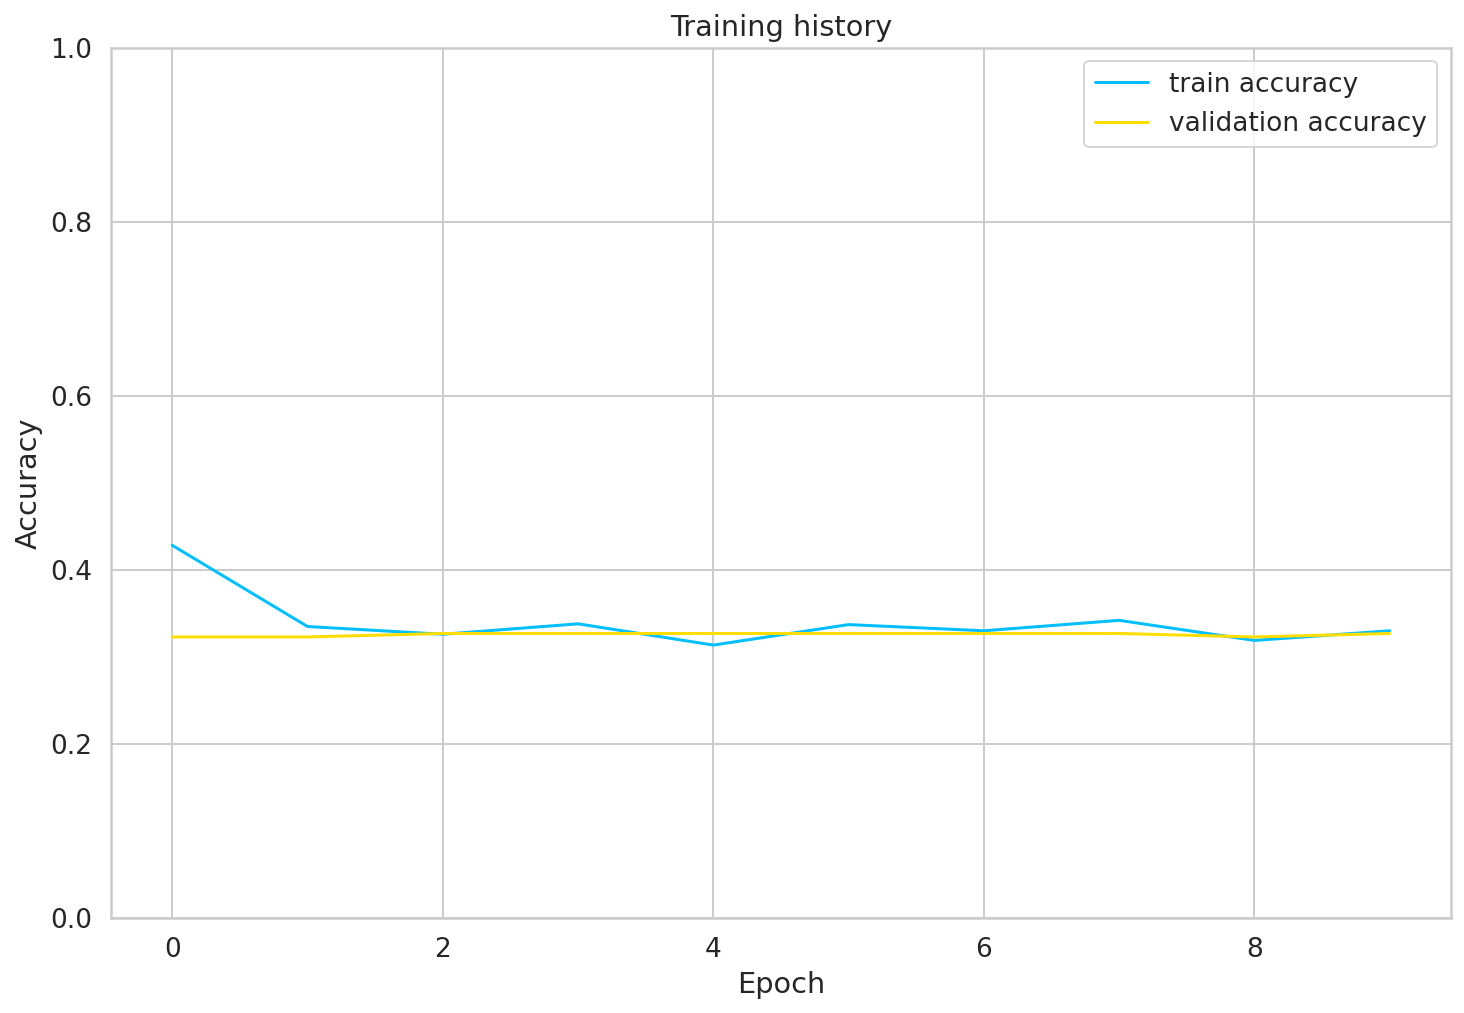

In [51]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [52]:
EPOCHS = 2

optimizer = AdamW(model.parameters(), lr=5e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [53]:
%%time
from IPython.utils import io

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  with io.capture_output() as captured:
    train_acc, train_loss = train_epoch(
      model,
      train_data_loader,    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      len(new_df_train)
    )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  with io.capture_output() as captured:
    val_acc, val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn, 
      device, 
      len(new_df_val)
    )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc
    

Epoch 1/2
----------
Train loss 1.137961743993962 accuracy 0.33822222222222226
Val   loss 1.0999277576487114 accuracy 0.32666666666666666

Epoch 2/2
----------
Train loss 1.1404879439807107 accuracy 0.3191111111111111
Val   loss 1.0981892702427316 accuracy 0.3506666666666667

CPU times: user 2min 25s, sys: 1min 48s, total: 4min 14s
Wall time: 4min 17s


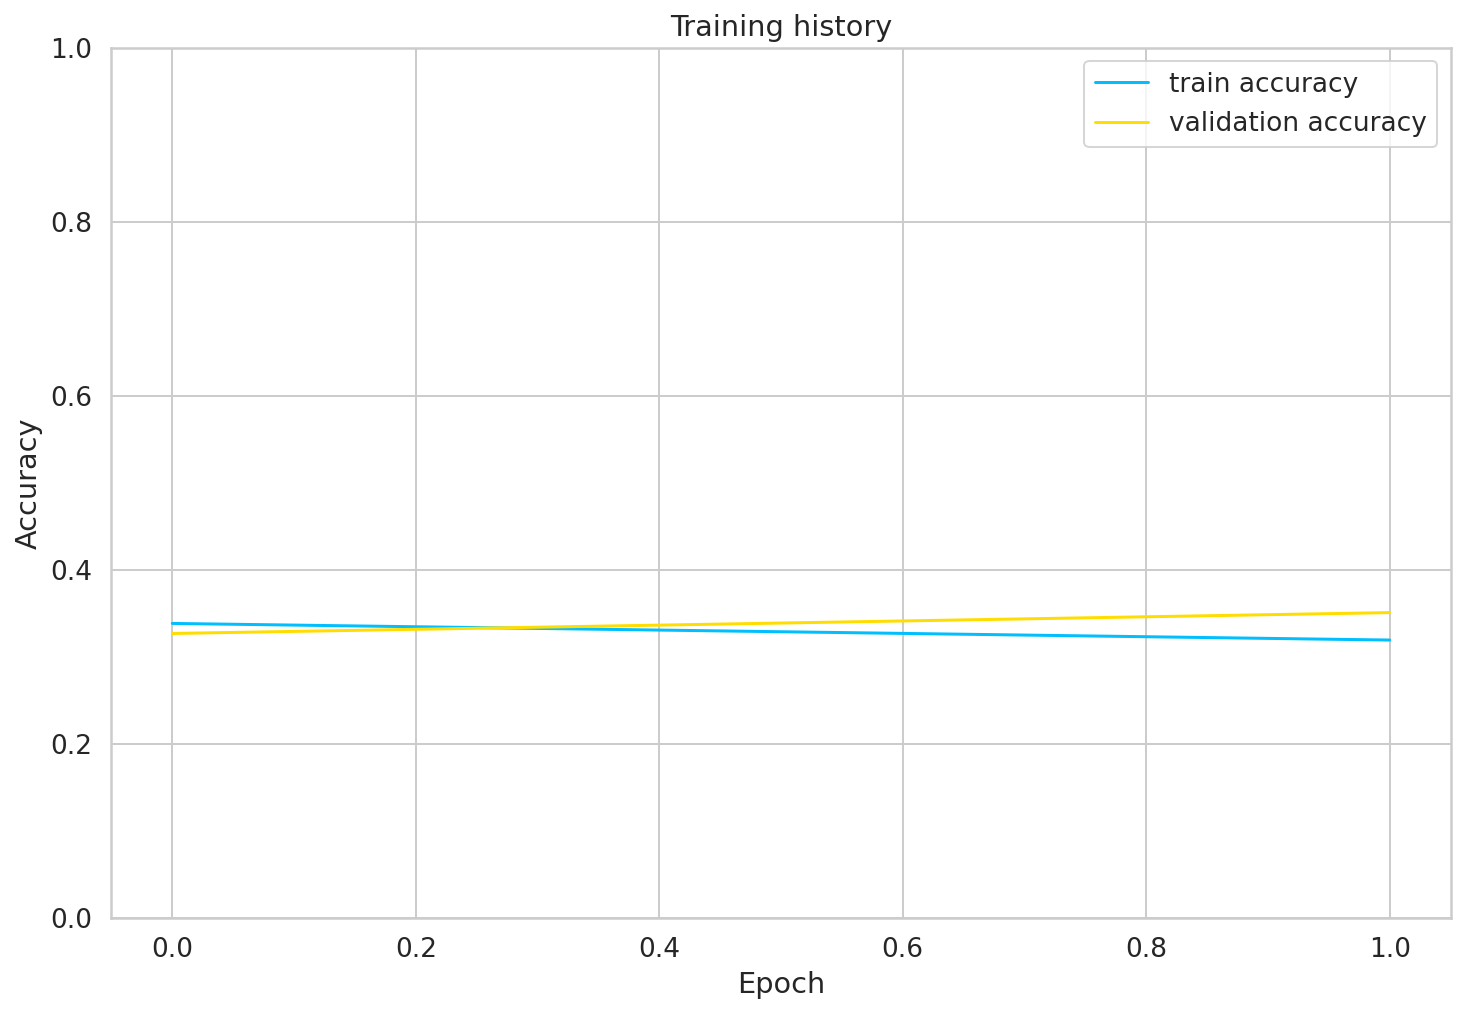

In [54]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

# Evaluation

In [56]:
%%capture
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(new_df2)
)



In [57]:
test_acc.item()

0.33333333333333337

In [58]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [60]:
%%capture
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [62]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       200
     neutral       0.33      1.00      0.50       200
    positive       0.00      0.00      0.00       200

    accuracy                           0.33       600
   macro avg       0.11      0.33      0.17       600
weighted avg       0.11      0.33      0.17       600



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


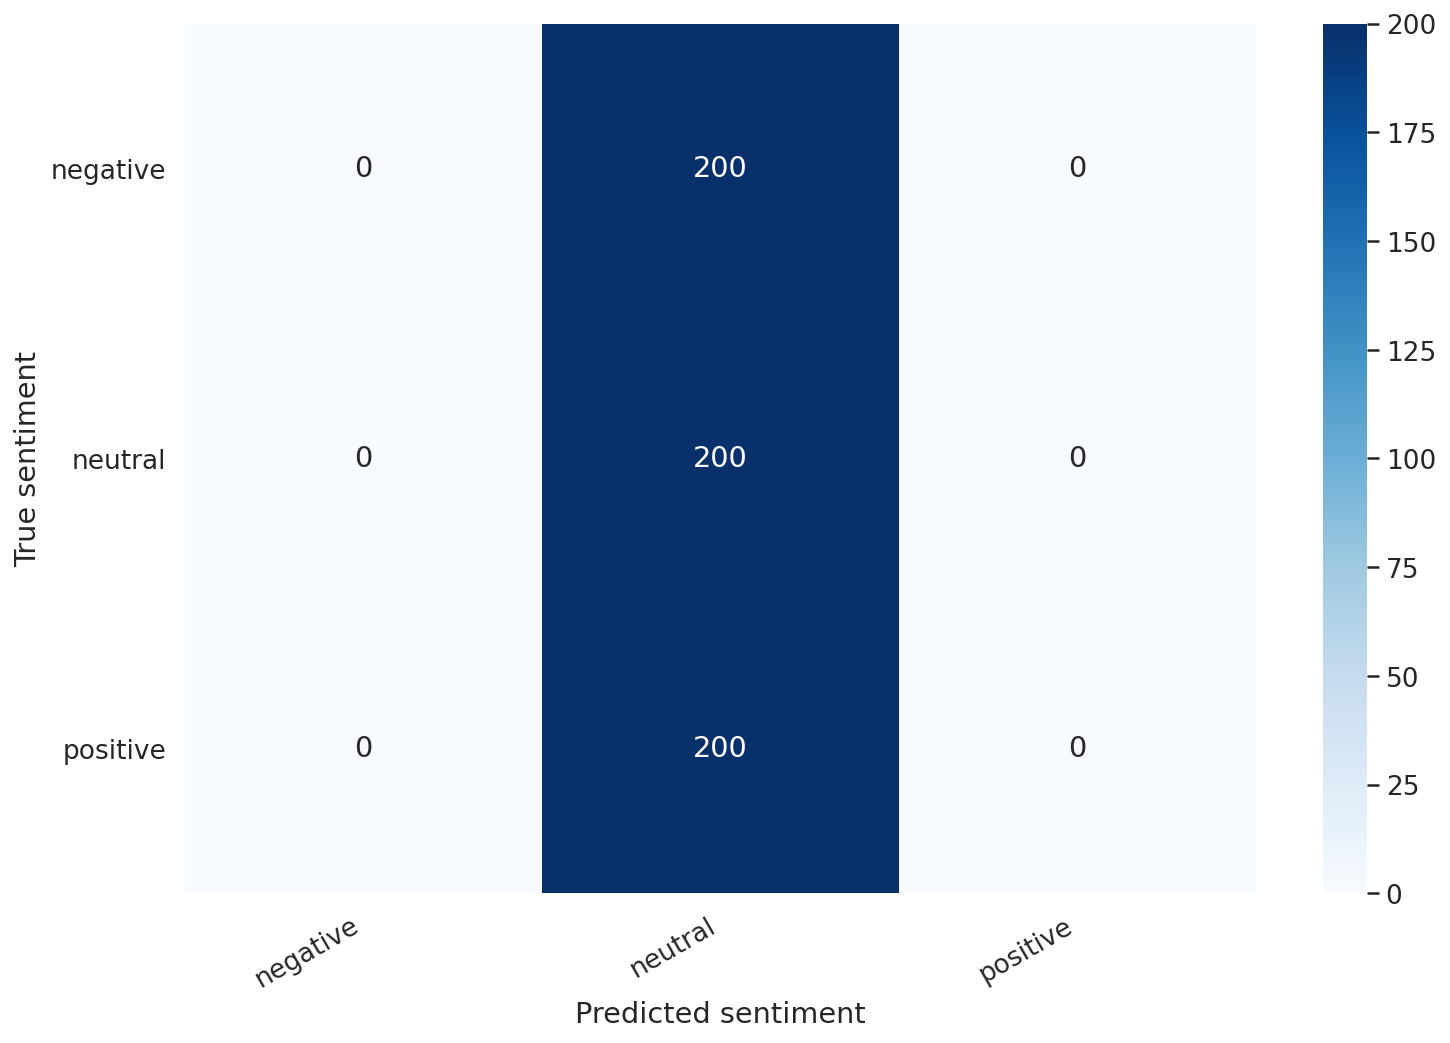

In [63]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

# Predicting on Raw Text

In [64]:
review_text = "@katezn take some aspirin quickly :)"

In [65]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [66]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: @katezn take some aspirin quickly :)
Sentiment  : neutral


In [67]:
review_text = "Like I started going back to the gym Monday then really started my class I take man I"

In [68]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [69]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: Like I started going back to the gym Monday then really started my class I take man I
Sentiment  : neutral


In [70]:
review_text = "@r_aaditya u a cartoonist?mentioned in ur profile,dats gr8 yar,me too an aspirin"

In [71]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [72]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: @r_aaditya u a cartoonist?mentioned in ur profile,dats gr8 yar,me too an aspirin
Sentiment  : neutral
